Source
- https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025
- https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html
- https://people.duke.edu/~ccc14/sta-663/MakingCodeFast.html

Code can be slow for different reasons

* **CPU-bound** - CPU is working flat out
* **Memory-bound** - Out of RAM - swapping to hard disk
* **IO-bound** - Lots of data transfer to and from hard disk
* **Network-bound** - CPU is waiting for data to come over network or from memory (“starvation”)

There is a natural order of making code fast
1. Cheat: Use sample data, solve a simpler problem, buy more RAM, etc.
2. **Profile**: Find out the bottlenecks
3. **Use better algorithms and data structures**
4. Using compiled code written in another language
5. Converting Python code to compiled code
6. Parallelize programs / execute in parallel

#### Magic commands for Jupyter

* `%time`: Time the execution of a single statement
* `%timeit`: Time repeated execution of a single statement for more accuracy
* `%prun`: Run code with the profiler
* `%lprun`: Run code with the line-by-line profiler
* `%memit`: Measure the memory use of a single statement
* `%mprun`: Run code with the line-by-line memory profiler

The last 3 commands are not bundled with Jupyter – you'll need to get the `line_profiler` and `memory_profiler` extension.

Also we use:

* `%%heat`
* `snakeviz`: visualizing the output of a profiling session

#### Timing Code Snippets: ``%timeit`` and ``%time``

The ``%timeit`` line-magic and ``%%timeit`` cell-magic can be used to time the repeated execution of snippets of code:

In [2]:
# % is line magic
# %% is cell magic

%timeit sum(range(100))     # timeit runs this 7 million times, iteration number depends on the size of the input

948 ns ± 93.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Because this operation is so fast, ``%timeit`` automatically does a large number of repetitions.
For slower commands, ``%timeit`` will automatically adjust and perform fewer repetitions:

In [3]:
%%timeit        # %% is cell magic
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

# now this is ran only 7 times, because input is very large, by default it tries to adjust automatically

310 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sometimes repeating an operation is not the best option.
For example, if we have a list that we'd like to sort, we might be misled by a repeated operation.
Sorting a pre-sorted list is much faster than sorting an unsorted list, so the repetition will skew the result:

In [4]:
import random
L = [random.random() for i in range(100000)]
%timeit L.sort()
# the number you get is not useful because list sorted only once, the other times timeit use the sorted list

387 µs ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


For this, the ``%time`` magic function may be a better choice. It also is a good choice for longer-running commands, when short, system-related delays are unlikely to affect the result.
Let's time the sorting of an unsorted and a presorted list:

In [5]:
import random
L = [random.random() for i in range(100000)]
print("sorting an unsorted list:")
%time L.sort()          # here use %time, not %timeit - and %time give you CPU times, Wall time etc. 

sorting an unsorted list:
CPU times: total: 15.6 ms
Wall time: 14.9 ms


In [6]:
print("sorting an already sorted list:")
%time L.sort()          # the 2nd time, the list is already sorted, so it's faster

sorting an already sorted list:
CPU times: total: 0 ns
Wall time: 3.05 ms


Wall time is the time that a clock on the wall would measure as having elapsed between the start of the process and 'now'.

The CPU times is the amount of time spent of the CPUs (can be much more than wall time if multi-core, for example).

The presorted list is much faster to sort. Notice also how much longer the timing takes with ``%time`` versus ``%timeit``, even for the presorted list! ``%timeit`` does some clever things under the hood to prevent system calls from interfering with the timing. For this reason, ``%timeit`` results are usually noticeably faster than ``%time`` results.

For ``%time`` as with ``%timeit``, using the double-percent-sign cell magic syntax allows timing of multiline scripts:

In [7]:
%%time
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

CPU times: total: 250 ms
Wall time: 353 ms


In [8]:
%time?

Docstring:
Time execution of a Python statement or expression.

The CPU and wall clock times are printed, and the value of the
expression (if any) is returned.  Note that under Win32, system time
is always reported as 0, since it can not be measured.

This function can be used both as a line and cell magic:

- In line mode you can time a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, you can time the cell body (a directly
  following statement raises an error).

This function provides very basic timing functionality.  Use the timeit
magic for more control over the measurement.

.. versionchanged:: 7.3
    User variables are no longer expanded,
    the magic line is always left unmodified.

Examples
--------
::

  In [1]: %time 2**128
  CPU times: user 0.00 s, sys: 0.00 s, total: 0.00 s
  Wall time: 0.00
  Out[1]: 340282366920938463463374607431768211456L

  In [2]: n = 1000000

  In [3]: %time sum(range(n))
  CPU times: user 1.20 s,

For more information on ``%time`` and ``%timeit``, as well as their available options, use the IPython help functionality (i.e., type ``%time?`` at the IPython prompt).

## Timing outside of Jupyter

In [9]:
from timeit import default_timer as timer

start = timer()
sum(range(100))
end = timer()
print(end - start)

7.519999780924991e-05


In [10]:
import time

start = time.perf_counter()
sum(range(100))
end = time.perf_counter()
print(end - start)

4.369999805931002e-05


## Profiling and Optimizing: Monte Carlo method example

In [11]:
from random import random

def estimate_pi(n = 10000000):
    """Estimate pi with monte carlo simulation."""
    in_circle = 0
    total = n
    
    while n != 0:
        prec_x = random()
        prec_y = random()
        if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
            in_circle += 1 # inside the circle
        n -= 1
        
    return 4 * in_circle / total

In [12]:
%time estimate_pi()

CPU times: total: 2.67 s
Wall time: 4.44 s


3.1412344

From now on, lets run `%timeit` always with the same parameters:

In [13]:
%timeit -r 2 -n 5 estimate_pi()     # -r 2 -n 5 means run 2 times, each time run 5 times

4.65 s ± 228 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


### cProfile
To learn what takes up most of the execution time, python ships with a great profiler, cProfile, breaking down the execution function by function. It causes our attention to shrink down to critical functions by handing out a high-level view of performance. In Jupyer, use the [`%prun`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun) magic:

In [14]:
%prun estimate_pi()

         40000004 function calls in 14.086 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    7.925    7.925   14.086   14.086 1200316338.py:3(estimate_pi)
 20000000    4.387    0.000    4.387    0.000 {built-in method builtins.pow}
 20000000    1.774    0.000    1.774    0.000 {method 'random' of '_random.Random' objects}
        1    0.000    0.000   14.086   14.086 {built-in method builtins.exec}
        1    0.000    0.000   14.086   14.086 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

The output will be written to stdout:<img src="files/profiling.png" width=1000>

The report shows for each function:
* the number of calls (ncalls)
* the total time (tottime) spent on it excluding calls to subfunctions
* how long each call took (percall, excluding and including)
* the total time (cumtime) including all calls to subfunctions

An another useful option is -s which enables sorting for a particular column. For example sorting cumulative time in descending order:

In [15]:
%prun -s cumulative estimate_pi()

         40000004 function calls in 12.637 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.637   12.637 {built-in method builtins.exec}
        1    0.000    0.000   12.637   12.637 <string>:1(<module>)
        1    7.109    7.109   12.637   12.637 1200316338.py:3(estimate_pi)
 20000000    3.926    0.000    3.926    0.000 {built-in method builtins.pow}
 20000000    1.602    0.000    1.602    0.000 {method 'random' of '_random.Random' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

If we wish to save the output for later inspection for example with [pstats](https://docs.python.org/3.7/library/profile.html#the-stats-class), use the -D option to save on disk. 

You can also just return the stats object with the -r option:

In [16]:
stats = %prun -r -q estimate_pi()   # -r means run 3 times, -q means quiet, no output

In [17]:
stats.sort_stats('tottime').print_stats(3);

         40000004 function calls in 10.126 seconds

   Ordered by: internal time
   List reduced from 6 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.705    5.705   10.126   10.126 1200316338.py:3(estimate_pi)
 20000000    3.130    0.000    3.130    0.000 {built-in method builtins.pow}
 20000000    1.291    0.000    1.291    0.000 {method 'random' of '_random.Random' objects}




The number of calls to built-in functions `pow()` and `random()` seems to take some time. Before we address this extensive number of calls, let’s have a look at a much more convenient library delivering even more concrete reports.

### Line profiler
The `%lprun` command yields the time spent on each line of code giving us a line by line report. Since not shipped by default, install the library

```bash
conda install line_profiler 
```

and load the extension manually in the notebook.

```python
%load_ext line_profiler
```

In [46]:
%load_ext line_profiler
stats_lprun = %lprun -r -f estimate_pi estimate_pi()    # -r means run 3 times, -f means function
# this will give you more information than before
stats_lprun.print_stats();      # most important is the % time column

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Timer unit: 1e-07 s

Total time: 21.8076 s

Could not find file C:\Users\jackh\AppData\Local\Temp\ipykernel_11108\1200316338.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           
     4                                           
     5         1         12.0     12.0      0.0  
     6         1          7.0      7.0      0.0  
     7                                           
     8  10000001   29678491.0      3.0     13.6  
     9  10000000   30594068.0      3.1     14.0  
    10  10000000   29754768.0      3.0     13.6  
    11  10000000   71119779.0      7.1     32.6  
    12   7853994   24941712.0      3.2     11.4  
    13  10000000   31986931.0      3.2     14.7  
    14                

Timer unit: 1e-07 s

Total time: 21.8076 s

Could not find file C:\Users\jackh\AppData\Local\Temp\ipykernel_11108\1200316338.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           
     4                                           
     5         1         12.0     12.0      0.0  
     6         1          7.0      7.0      0.0  
     7                                           
     8  10000001   29678491.0      3.0     13.6  
     9  10000000   30594068.0      3.1     14.0  
    10  10000000   29754768.0      3.0     13.6  
    11  10000000   71119779.0      7.1     32.6  
    12   7853994   24941712.0      3.2     11.4  
    13  10000000   31986931.0      3.2     14.7  
    14                                           
    15         1         20.0     20.0      0.0

Notice the extensive time (~28%) spent on the if statement on line 11.

#### Visualizing the profile with heat

```bash
pip install py-heat-magic
```

and load the extension manually in the notebook:

In [21]:
%load_ext heat

This code can take a minute or two to execute:

c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\pyheat\pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


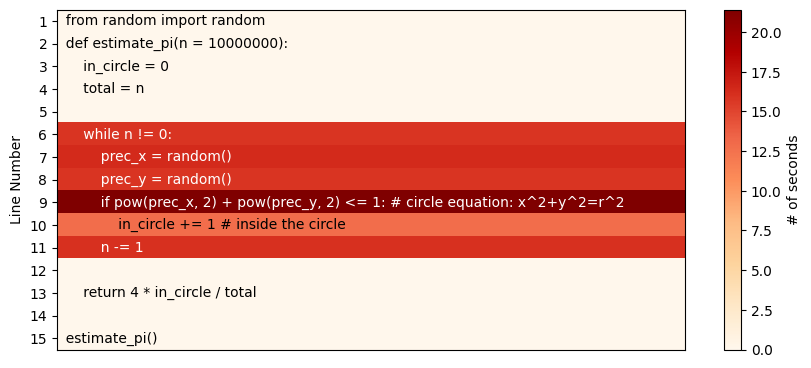

In [22]:
%%heat
from random import random
def estimate_pi(n = 10000000):
    in_circle = 0
    total = n
    
    while n != 0:
        prec_x = random()
        prec_y = random()
        if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
            in_circle += 1 # inside the circle
        n -= 1
        
    return 4 * in_circle / total

estimate_pi()

### Optimization

```python
def estimate_pi(n = 10000000):
    in_circle = 0
    total = n
    
    while n != 0:
        prec_x = random()
        prec_y = random()
        if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
            in_circle += 1 # inside the circle
        n -= 1
        
    return 4 * in_circle / total
```

#### Algorithmic optimization
Our code is easy to read, but slow, because of:
* while loop
* function calls: pow()

We can replace the whole function with one line!:

In [25]:
def estimate_pi_oneliner(n=1e7):
    return 4 * sum(1 for _ in range(int(n)) if random()**2 + random()**2 <= 1) / n
# when use ( __ ) instead of [ __ ], it's faster because it's a generator

In [47]:
stats_oneliner = %prun -r -q estimate_pi_oneliner()
stats_oneliner.sort_stats('tottime').print_stats(3);

          27853922 function calls in 6.441 seconds

   Ordered by: internal time
   List reduced from 7 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  7853917    4.601    0.000    5.731    0.000 3474053777.py:2(<genexpr>)
 20000000    1.130    0.000    1.130    0.000 {method 'random' of '_random.Random' objects}
        1    0.710    0.710    6.441    6.441 {built-in method builtins.sum}




In [28]:
%timeit -r 2 -n 5 estimate_pi_oneliner()

3.63 s ± 159 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


From 4.02 to 2.59 seconds: Over 30% improvement!

**What did we do?**
* <span style="color:green">Replace `pow()` with `**`</span>
* <span style="color:green">Replace `while` with `sum(.. for .. in range(n))`</span>
* <span style="color:red">Made the function really hard to read for humans</span>

This is a **generator expression**: `sum(.. for .. in range(n))`

Iterables: Everything that you can use in a for loop. For example:

In [29]:
mylist = [0, 1, 4]
for i in mylist:
    print(i)

0
1
4


In [30]:
mylist = [x*x for x in range(3)]
for i in mylist:
    print(i)

0
1
4


Generators are iterators, but *you can only iterate over them once*. It’s because they do not store all the values in memory, they generate the values on the fly:

In [31]:
mygenerator = (x*x for x in range(3))
for i in mygenerator:
    print(i)

0
1
4


In [32]:
for i in mygenerator:
    print(i)
# Nothing happens

Generators are useful if you run into memory issues.

##### You can create a generator with yield
Yield is a keyword that is used like return, except the function will return a generator.

In [33]:
def createGenerator():
    mylist = range(3)
    for i in mylist:
        yield i*i

mygenerator = createGenerator() # create a generator
print(mygenerator) # mygenerator is an object!

for i in mygenerator:
    print(i)

<generator object createGenerator at 0x000001C17FF4B7D0>
0
1
4


The first time the for calls the generator object created from your function, it will run the code in your function from the beginning until it hits yield, then it’ll return the first value of the loop. Then, each other call will run the loop you have written in the function one more time, and return the next value, until there is no value to return.

#### Optimization through vectorization

All our operations are still inside the "loop":
```python
sum(1 for _ in range(int(n)) if random()**2 + random()**2 <= 1)
```
    
So we are calling `random()` 2*n times, and we call `if` n times. Do we really need to?

Vectorized version, using numpy:

In [34]:
import numpy as np
# numpy is faster than before b/c it's written in C
def estimate_pi_vectorized(n=10000000):
    xy = np.random.rand(n, 2)       # 2D array, each row is a point, two columns are x and y
    inside = np.sum(xy[:, 0]**2 + xy[:, 1]**2 <= 1)
    return 4 * inside / n

In [35]:
%timeit -r 2 -n 5 estimate_pi_vectorized()

249 ms ± 6.03 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


4.02 seconds to 0.3 seconds: We are 12 times faster than in the beginning!

### Memory profiling - THIS IS NOT IMPORTANT ANYMORE, NUMPY HAS UPGRADED ITS IMPLEMENTATION

```bash
Juggling with large data sets involves having a clear sight of memory consumption and allocation processes going on in the background.

After installing the memory profiler,
```bash
conda install memory_profiler 
```

we can explore memory usage with `%memit`

In [36]:
%load_ext memory_profiler

In [37]:
%memit estimate_pi_vectorized()

peak memory: 275.38 MiB, increment: 162.20 MiB


This is a lot of memory. When we allocate things differently, we can reduce it:

In [38]:
def estimate_pi_vectorized_oneliner(n=10000000):
    return np.sum(np.random.random(n)**2 + np.random.random(n)**2 <= 1) / n * 4

In [39]:
%memit estimate_pi_vectorized_oneliner()

peak memory: 323.71 MiB, increment: 210.45 MiB


Also, we improved runtime:

In [40]:
%timeit -r 2 -n 5 estimate_pi_vectorized_oneliner()

292 ms ± 41.7 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


3.67 seconds to 0.227 seconds: We are now 16 times faster than in the beginning!

## Summary of  most effective optimization techniques

* Use better algorithms and data structures
* Avoid loops
* Vectorize (numpy)
* Avoid function calls and dot notation
* Memory: Use views, not copies
* Memory: Use generators
* Use compiled code

### Use better algorithms and data structures, avoid loops

* General explanation of time complexity: https://towardsdatascience.com/understanding-time-complexity-with-python-examples-2bda6e8158a7
* Time complexity of Python data structures: https://wiki.python.org/moin/TimeComplexity

### Avoid function calls and dot notation

#### Example: Looped function calls
In the following example, the function `inner` is called for each element in the list. The overhead of the function call and the argument checking is multiplied 100000 times. (From https://nyu-cds.github.io/python-performance-tips/04-functions/)

In [44]:
x = 0
def inner(i):
    global x
    x = x + i
    
def outer1():
    for i in range(100000): 
        inner(i)        # inner function is called 100000 times
        
%timeit outer1()

27.8 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here instead, the loop is moved inside the aggregate function so that the function is only called once instead of 100000 times:

In [45]:
x = 0
def aggregate(list):
    global x
    for i in list:
        x = x + i

def outer2():
    aggregate(range(100000))    # aggregate function is called 1 time
    
%timeit outer2()

8.14 ms ± 867 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Example: Avoid dot notation

Use first class functions instead of dot notation:

Slow:

```python
for i in range(n):
    myObj.func(i)
```

Fast:

```python
myfunc = myObj.func
for i in range(n):
    myfunc(i)
```

## Use compiled code

### Cython
http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html

Cython is Python with C data types.

Cython is Python: Almost any piece of Python code is also valid Cython code. The Cython compiler will convert it into C code which makes equivalent calls to the Python/C API.

### Pypy
https://pypy.org/

Alternative implementaiton of Cython using a just-in-time compiler instead of an interpreter, often making it run faster.

## When things go slow, use a progress bar: tqdm

https://tqdm.github.io/presentation-%28pydata%29/video/